# COVID-19 Classification from Chest X-ray Images using ResNet50, DenseNet, and EfficientNetB0
#### by TzuHung Cheng

## 1. Introduction
COVID-19 remains a global challenge, necessitating rapid and accurate diagnostic tools. While RT-PCR tests are the standard, they can be time-consuming and resource-intensive. Chest X-ray imaging, which is faster and more widely accessible, has become a critical diagnostic aid. However, manual interpretation of X-ray images is subjective and error-prone, particularly when performed under high workloads or by less experienced radiologists.

This project applies transfer learning to three CNN architectures—EfficientNetB0, DenseNet201, and ResNet50 — to classify COVID-19 chest X-ray images. We are going to compare the effectiveness of these models in terms of accuracy.

## 2. Libraries
The following Python libraries were used in this project to facilitate:
- Data manipulation: Numpy, Pandas, OS
- Model training: Tensorflow, Keras
- Evaluation: Scikit-Learn
- Visualization: Matplotlib, Seaborn

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL
import seaborn as sns

#show plots in jupyter notebook
%matplotlib inline

## 3. Dataset

The dataset used in this study is the COVID-19 Chest X-ray dataset from Kaggle: https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image/data

The dataset consists of over 6000 labeled images divided into COVID-19, Pneumonia and Normal classes.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# train_dir = "archive/Data/train"
# test_dir = "archive/Data/test"

train_dir = "gdrive/MyDrive/archive/Data/train"
test_dir = "gdrive/MyDrive/archive/Data/test"

### 3.1 Data Visualization

#### 3.1.1 Normal Dataset

In [4]:
normal_dir = os.path.join(train_dir, "NORMAL")

# List the contents of the NORMAL directory
normal_files = os.listdir(normal_dir)

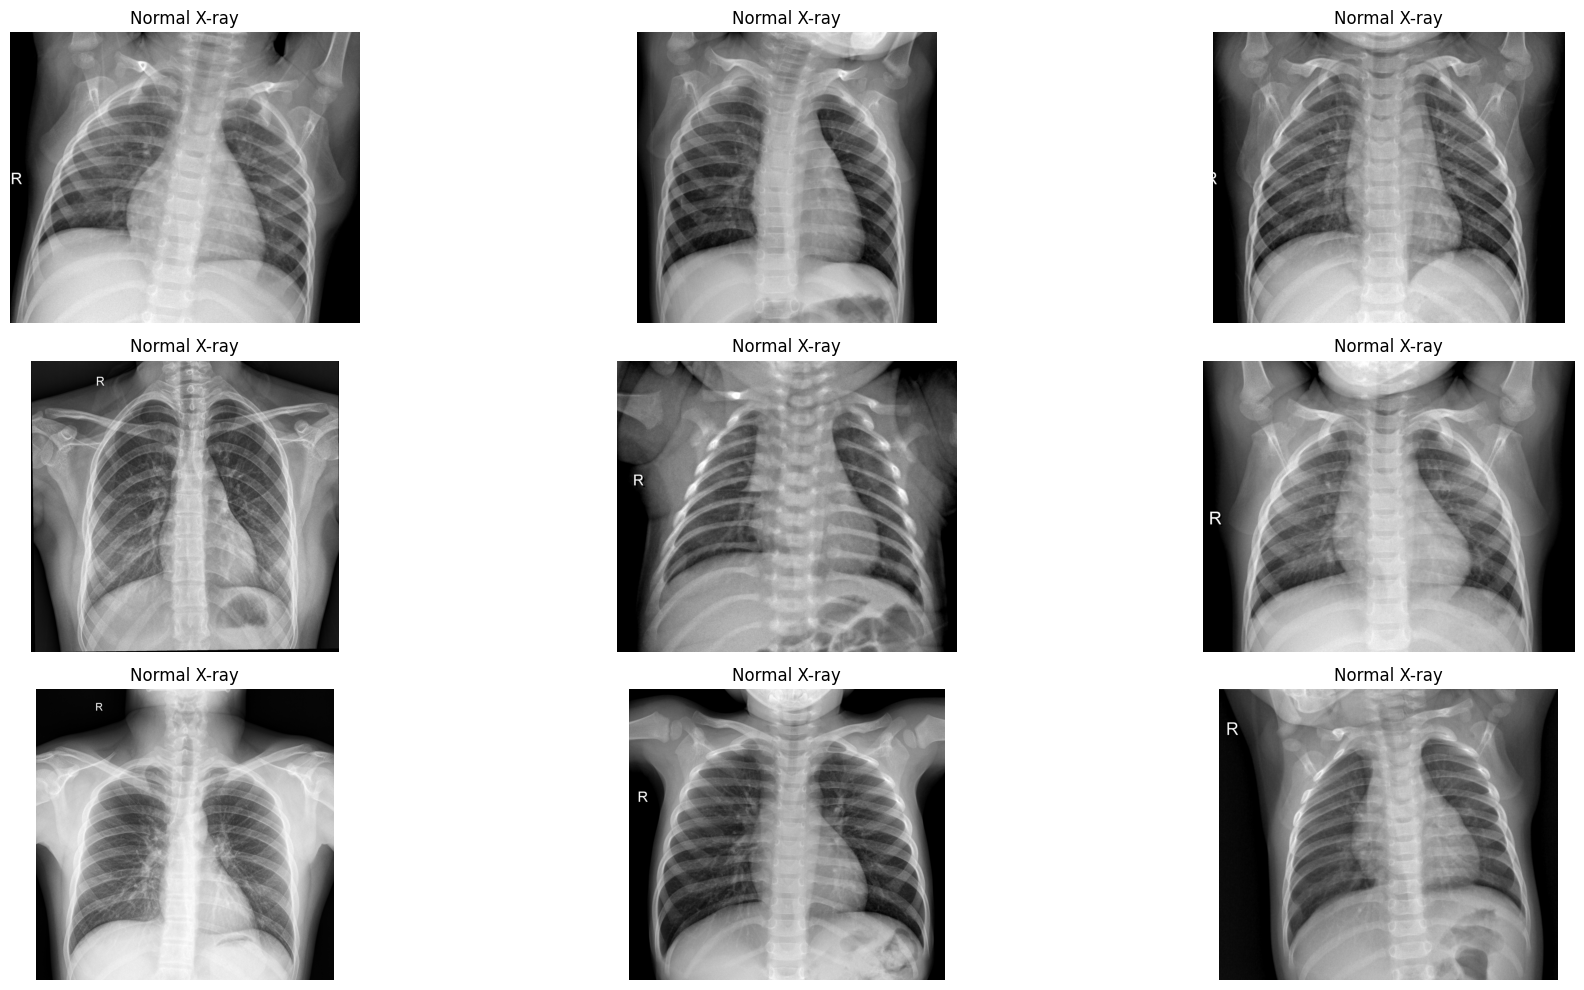

In [5]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal_files[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

#### 3.1.2 Pneumonia Dataset

In [6]:
pneumonia_dir = os.path.join(train_dir, "PNEUMONIA")

# List the contents of the PNEUMONIA directory
pneumonia_files = os.listdir(pneumonia_dir)

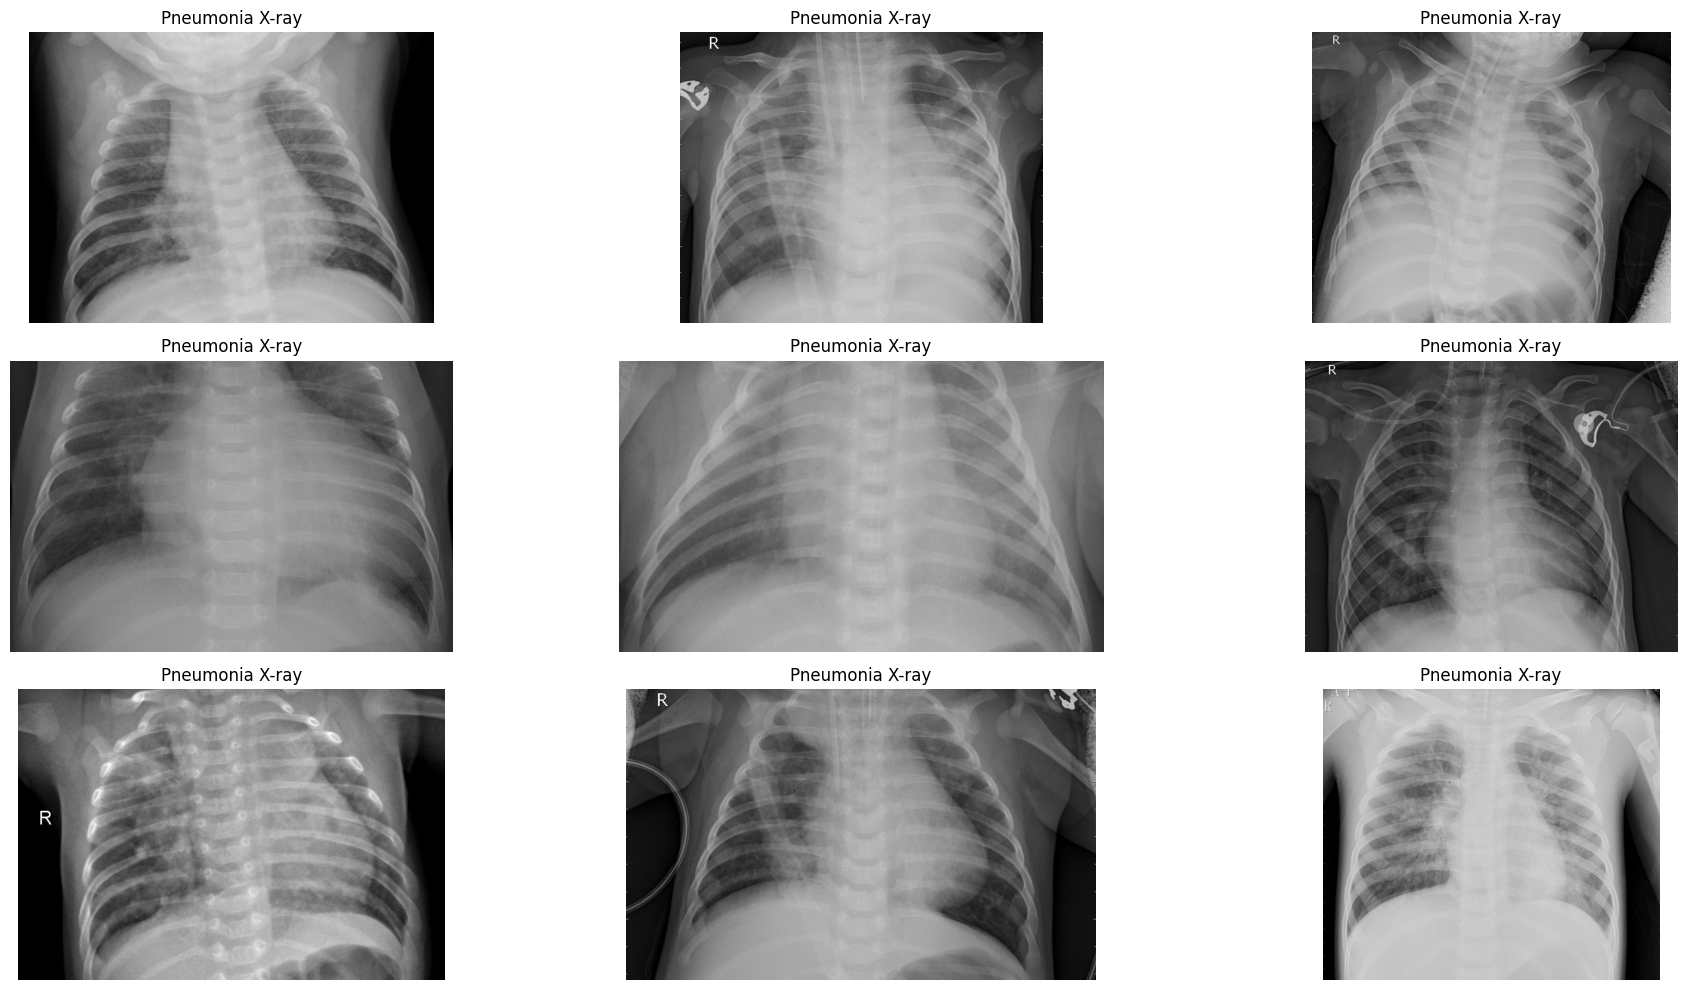

In [7]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia_files[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

#### 3.1.3 Covid19 Dataset

In [8]:
covid19_dir = os.path.join(train_dir, "COVID19")

# List the contents of the COVID19 directory
covid19_files = os.listdir(covid19_dir)

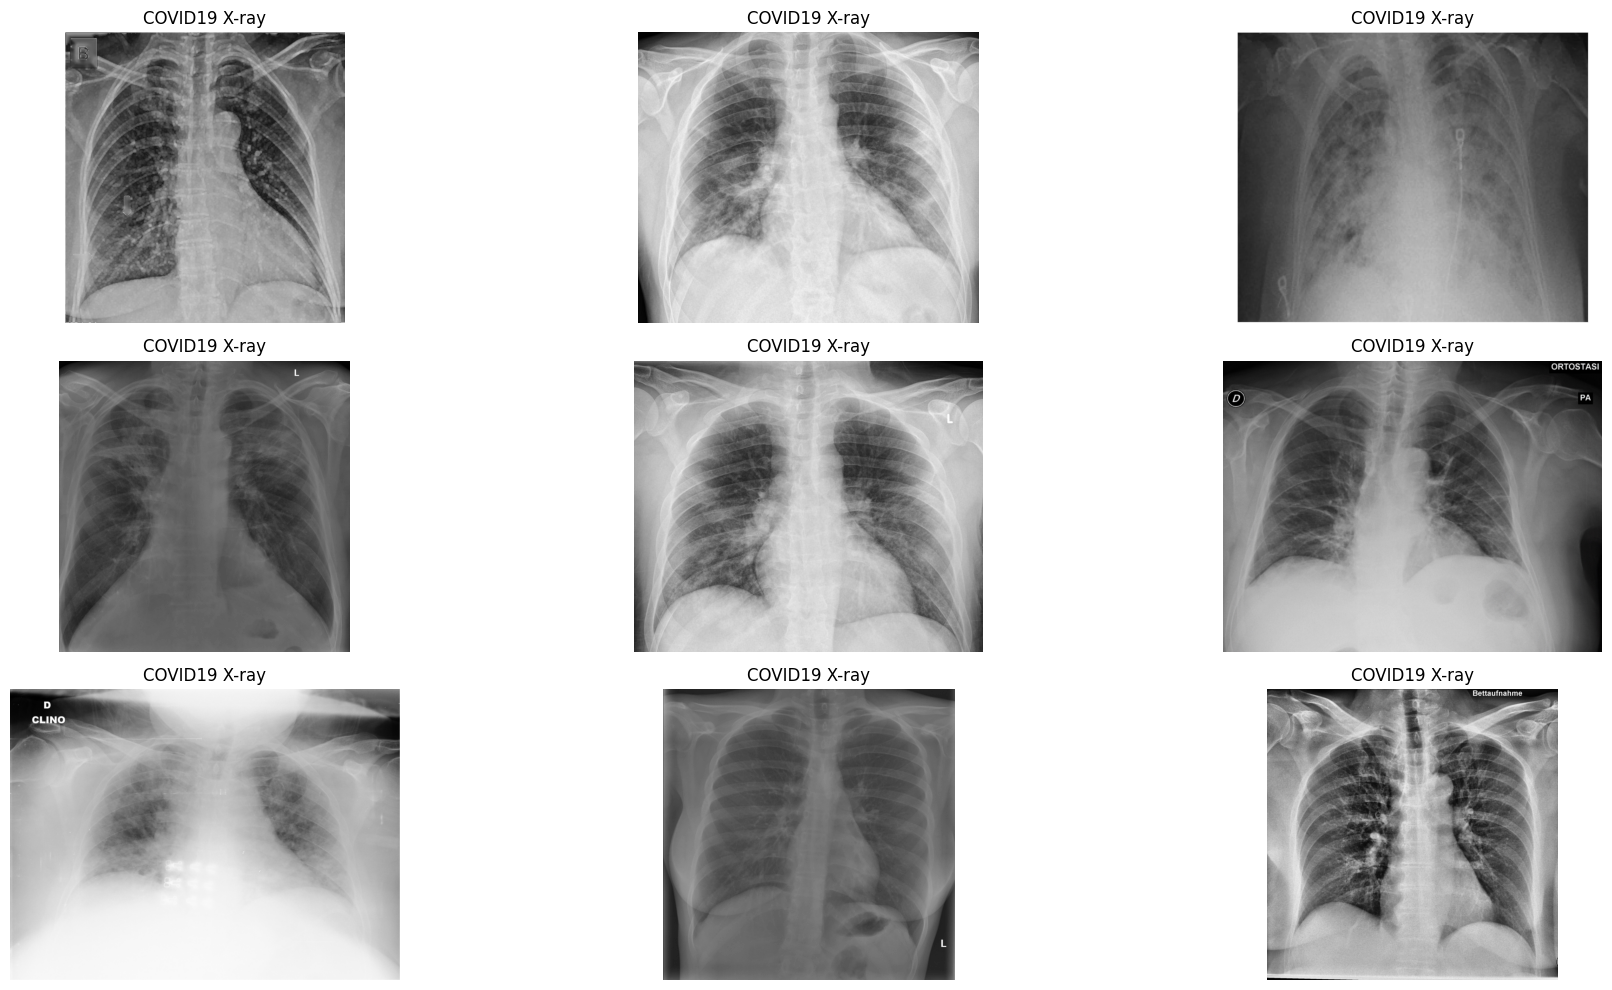

In [9]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(covid19_dir, covid19_files[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("COVID19 X-ray")
plt.tight_layout()

### 3.2 Data Distribution
The dataset is extremely unbalanced, the images of the pneumonia category outnumber the normal and COVID-19 categories.

In [10]:
labels = ['PNEUMONIA','NORMAL','COVID19']
def get_data(data_dir):
    data=[]

    for label in labels:
        count = 0
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            count += 1
        data.append([label,count])
    return np.array(data)

<ipython-input-11-e9da1e8f7877>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=df, palette='viridis')


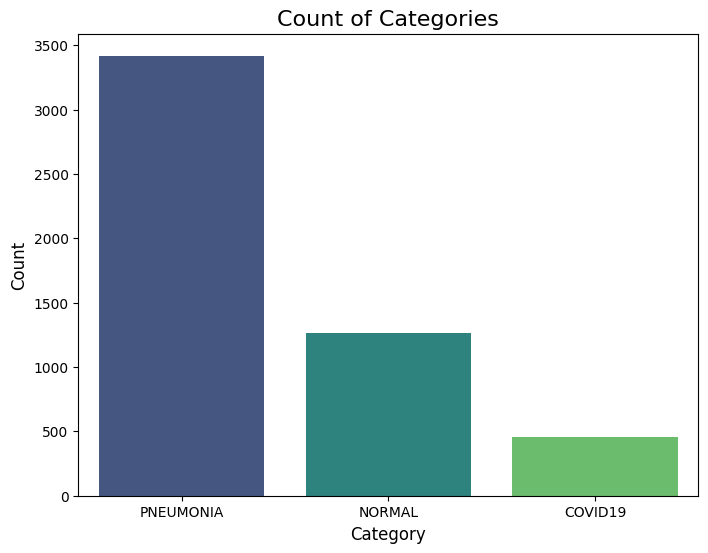

In [11]:
train = get_data(train_dir)
test = get_data(test_dir)

df = pd.DataFrame(train, columns=['Category', 'Count'])
df['Count'] = df['Count'].astype(int)  # Ensure counts are integers

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=df, palette='viridis')
plt.title('Count of Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### 3.3 Splitting Data
A validation set is used to fine tune and optimize a model, and is considered to be part of the training phase. Applying the validation set helps prevent overfitting

In [12]:
IMG_SIZE = (224,224)

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.20)


train_ds = data.flow_from_directory(train_dir,
                                    class_mode = "categorical",
                                    target_size = IMG_SIZE,
                                    batch_size = 32,
                                    shuffle = True,
                                    subset='training',
                                    seed = 42)

Found 4116 images belonging to 3 classes.


In [13]:
validation = data.flow_from_directory(train_dir,
                                      class_mode = "categorical",
                                      target_size = IMG_SIZE,
                                      batch_size = 32,
                                      shuffle = True,
                                      subset='validation',
                                      seed = 42)

Found 1028 images belonging to 3 classes.


In [14]:
datagen = ImageDataGenerator(
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=False,
)

Found 1288 images belonging to 3 classes.


## 4. Training models

### **4.1 ResNet50**
ResNet-50 is a convolutional neural network that is 50 layers deep.
The ResNet model architecture allows the training error to be reduced with a deeper network through connection skip.
The feature of residual connections enable the model to learn deeper representations without degradation of performance.

#### 4.1.1 Pre-trained model
The pre-trained ResNet50 model was used for feature extraction. Initial layers were frozen during early training to retain general features.

In [15]:
# Load pre-train model
resnet_base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape = (*IMG_SIZE, 3))
# Freeze the pre-trained layers
resnet_base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 4.1.2 Customized Layers
- GlobalAveragePooling2D layer to condense feature maps.
- Dense layer and ReLU activation for high-level feature learning.
- Dropout layer to reduce overfitting.
- Dense layer with softmax activation for output probabilities.

In [35]:
# Add some more layers to the base model for our requirements
resnet_model = tf.keras.Sequential([
    resnet_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

resnet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,435 (91.01 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### 4.1.3 Optimizer
Combines the benefits of adaptive learning rate methods and momentum, making it efficient for training deep networks.
Automatically adjusts the learning rate, accelerating convergence and reducing manual tuning.

In [17]:
resnet_model.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

#### 4.1.4 EarlyStopping Callback
Prevents overfitting and unnecessary computation by stopping training early

In [18]:
# Define an EarlyStopping callback instance with optimized parameters:
callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Track validation loss
        patience=5,         # Wait for 5 epochs without improvement
        restore_best_weights=True,  # Restore best weights found so far
        min_delta=0.001,   # Consider improvement only if greater than 0.1%
        verbose=1          # Log messages during training
    ),
    ReduceLROnPlateau(
        monitor='val_loss', # Track validation loss
        factor=0.5,
        patience=2,        # Wait for 2 epochs without improvement
        verbose=1          # Log messages during training
    )
]

In [19]:
resnet_history = resnet_model.fit(train_ds,
            epochs=30,
            verbose=1,
            validation_data=validation,
            callbacks=[callbacks]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 1095s 8s/step - accuracy: 0.5731 - loss: 1.0978 - val_accuracy: 0.9115 - val_loss: 0.2794 - learning_rate: 1.0000e-04
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 68s 505ms/step - accuracy: 0.8585 - loss: 0.3605 - val_accuracy: 0.9348 - val_loss: 0.1937 - learning_rate: 1.0000e-04
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 485ms/step - accuracy: 0.8963 - loss: 0.2662 - val_accuracy: 0.9475 - val_loss: 0.1534 - learning_rate: 1.0000e-04
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 480ms/step - accuracy: 0.9165 - loss: 0.2234 - val_accuracy: 0.9465 - val_loss: 0.1499 - learning_rate: 1.0000e-04
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 483ms/step - accuracy: 0.9257 - loss: 0.1994 - val_accuracy: 0.9446 - val_loss: 0.1468 - learning_rate: 1.0000e-04
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 483ms/step - accuracy: 0.9337 - loss: 0.1727 - val_accuracy: 0.9533 - val_loss: 0.1355 - learning_rate: 1.0000e-04
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 64s 473ms/step - a

#### 4.1.5 Training and validation metrics

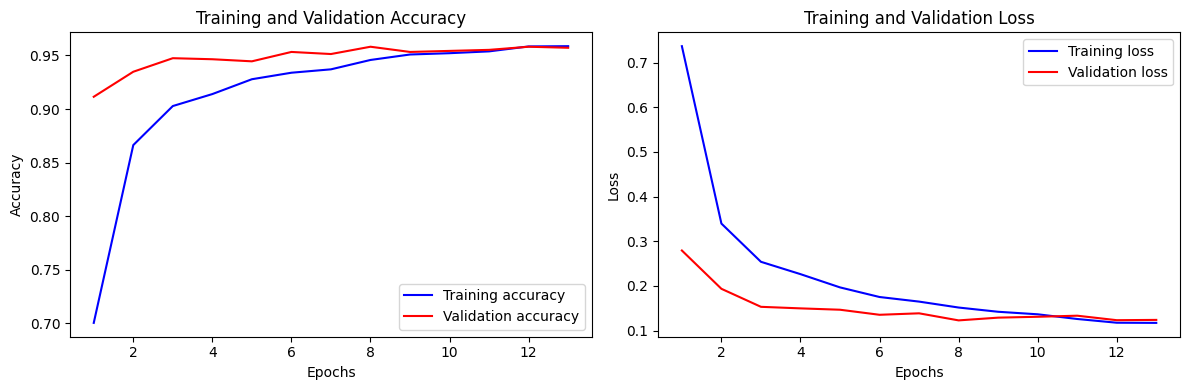

In [34]:
    # Extracting training and validation metrics from the history object
    resnet_train_acc = resnet_history.history['accuracy']
    resnet_val_acc = resnet_history.history['val_accuracy']
    resnet_train_loss = resnet_history.history['loss']
    resnet_val_loss = resnet_history.history['val_loss']

    epochs = range(1, len(resnet_train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, resnet_train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, resnet_val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, resnet_train_loss, 'b', label='Training loss')
    plt.plot(epochs, resnet_val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### 4.1.6 Prediction

In [22]:
resnet_predictions=resnet_model.predict(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 361ms/step


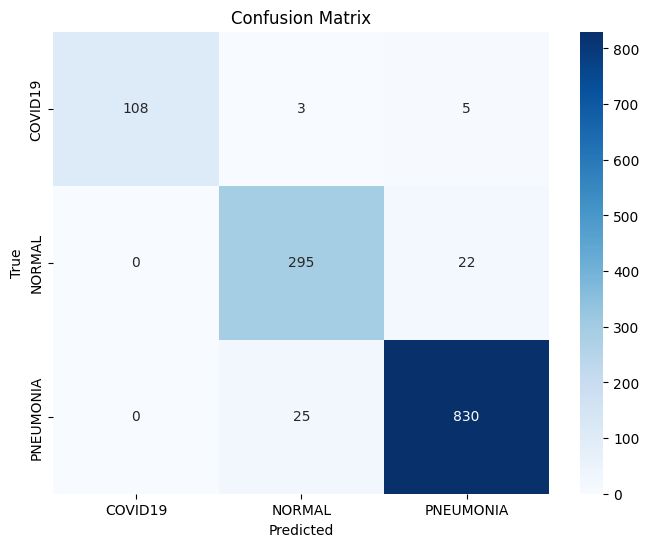

Classification Report:
               precision    recall  f1-score   support

     COVID19       1.00      0.93      0.96       116
      NORMAL       0.91      0.93      0.92       317
   PNEUMONIA       0.97      0.97      0.97       855

    accuracy                           0.96      1288
   macro avg       0.96      0.94      0.95      1288
weighted avg       0.96      0.96      0.96      1288



In [23]:
# Get true labels
true_labels = test_generator.classes

# Use the model to predict the classes
resnet_predicted_labels = np.argmax(resnet_model.predict(test_generator), axis=1)

# Generate confusion matrix
resnet_cm = confusion_matrix(true_labels, resnet_predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(true_labels, resnet_predicted_labels, target_names=test_generator.class_indices.keys()))

### **4.2 DenseNet**
Dense connections promote feature reuse, making the model highly efficient in extracting intricate patterns.
It is ideal for detecting subtle differences in medical imaging data, such as identifying early-stage COVID-19 features.

#### 4.2.1 Training the model

In [36]:
densenet_base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape = (*IMG_SIZE, 3))

# Freeze the pre-trained layers
densenet_base_model.trainable = False

densenet_model = tf.keras.Sequential([
    densenet_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

densenet_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

densenet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         491,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,815,555 (71.78 MB)

 Trainable params: 493,059 (1.88 MB)

 Non-trainable params: 18,322,496 (69.89 MB)

In [25]:
densenet_history = densenet_model.fit(train_ds,
            epochs=30,
            verbose=1,
            validation_data=validation,
            callbacks=[callbacks]
)

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 154s 864ms/step - accuracy: 0.7393 - loss: 0.7665 - val_accuracy: 0.7286 - val_loss: 0.7596 - learning_rate: 0.0010
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 486ms/step - accuracy: 0.8952 - loss: 0.2905 - val_accuracy: 0.9397 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 485ms/step - accuracy: 0.9238 - loss: 0.2016 - val_accuracy: 0.8648 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 4/30
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9281 - loss: 0.1938
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 491ms/step - accuracy: 0.9280 - loss: 0.1939 - val_accuracy: 0.9163 - val_loss: 0.2149 - learning_rate: 0.0010
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 490ms/step - accuracy: 0.9405 - loss: 0.1621 - val_accuracy: 0.9241 - val_loss: 0.1901 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the

#### 4.2.2 Training and validation metrics

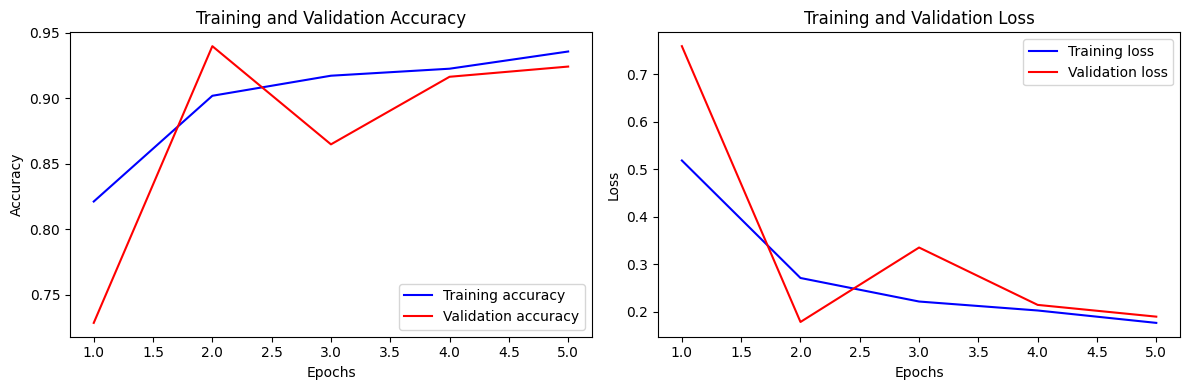

In [26]:
    # Extracting training and validation metrics from the history object
    densenet_train_acc = densenet_history.history['accuracy']
    densenet_val_acc = densenet_history.history['val_accuracy']
    densenet_train_loss = densenet_history.history['loss']
    densenet_val_loss = densenet_history.history['val_loss']

    epochs = range(1, len(densenet_train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, densenet_train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, densenet_val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, densenet_train_loss, 'b', label='Training loss')
    plt.plot(epochs, densenet_val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### 4.2.3 Prediction

In [27]:
densenet_predictions=densenet_model.predict(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 828ms/step


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step


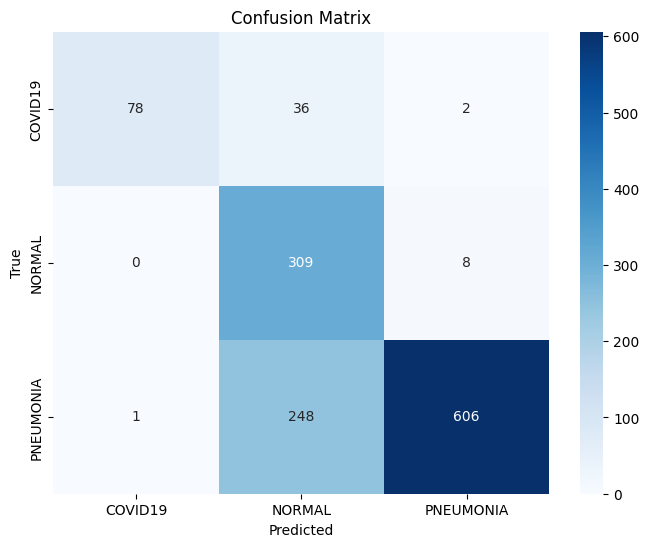

Classification Report:
               precision    recall  f1-score   support

     COVID19       0.99      0.67      0.80       116
      NORMAL       0.52      0.97      0.68       317
   PNEUMONIA       0.98      0.71      0.82       855

    accuracy                           0.77      1288
   macro avg       0.83      0.79      0.77      1288
weighted avg       0.87      0.77      0.79      1288



In [28]:
# Use the model to predict the classes
densenet_predicted_labels = np.argmax(densenet_model.predict(test_generator), axis=1)

# Generate confusion matrix
densenet_cm = confusion_matrix(true_labels, densenet_predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(densenet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(true_labels, densenet_predicted_labels, target_names=test_generator.class_indices.keys()))

### **4.3 EfficientNet**
EfficientNetB0 is a convolutional neural network (CNN) architecture known for its impressive balance of accuracy and efficiency. It uses a compound coefficient to uniformly scales network width, depth and resolution in a principled way. This method enables the creation of models that are both highly accurate and computationally efficient. This makes it a compelling choice for image classification tasks with limited resources, such as chest X-ray analysis

#### 4.3.1 Training the model

In [29]:
efficientnet_base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Freeze the pre-trained layers
efficientnet_base_model.trainable = False

# Build your custom model on top of the pre-trained base model
efficientnet_model = tf.keras.Sequential([
    efficientnet_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])  # 3 output classes

# Compile the model
efficientnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if your labels are integers
              metrics=['accuracy'])

# Display the model summary
efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [30]:
# Train the model with the EarlyStopping callback:
efficientnet_history = efficientnet_model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=validation,
    callbacks=[callbacks]
)

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 115s 701ms/step - accuracy: 0.8157 - loss: 0.4379 - val_accuracy: 0.9494 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 486ms/step - accuracy: 0.9212 - loss: 0.2013 - val_accuracy: 0.9562 - val_loss: 0.1358 - learning_rate: 0.0010
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 485ms/step - accuracy: 0.9452 - loss: 0.1507 - val_accuracy: 0.9523 - val_loss: 0.1412 - learning_rate: 0.0010
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 491ms/step - accuracy: 0.9498 - loss: 0.1362 - val_accuracy: 0.9650 - val_loss: 0.1171 - learning_rate: 0.0010
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 485ms/step - accuracy: 0.9408 - loss: 0.1408 - val_accuracy: 0.9562 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 66s 487ms/step - accuracy: 0.9549 - loss: 0.1322 - val_accuracy: 0.9630 - val_loss: 0.1159 - learning_rate: 0.0010
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 483ms/step - accuracy: 0.

#### 4.3.2 Training and validation metrics

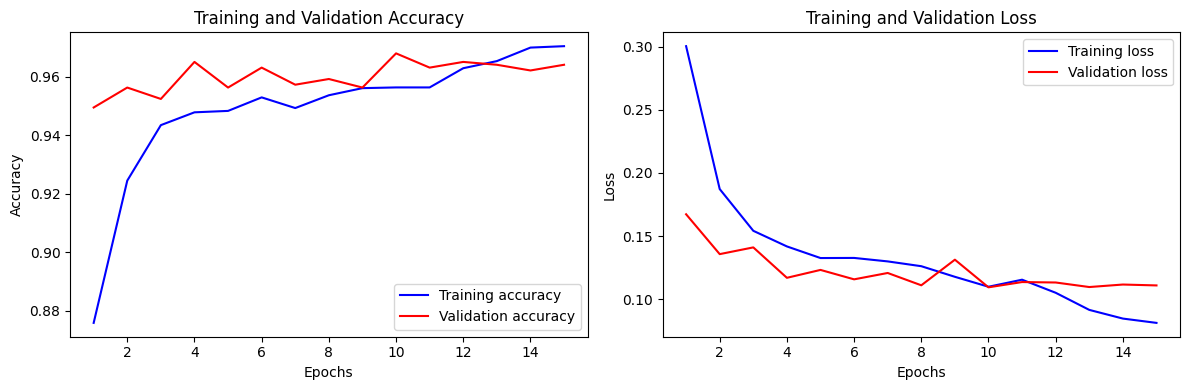

In [31]:
    # Extracting training and validation metrics from the history object
    efficientnet_train_acc = efficientnet_history.history['accuracy']
    efficientnet_val_acc = efficientnet_history.history['val_accuracy']
    efficientnet_train_loss = efficientnet_history.history['loss']
    efficientnet_val_loss = efficientnet_history.history['val_loss']

    epochs = range(1, len(efficientnet_train_acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, efficientnet_train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, efficientnet_val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, efficientnet_train_loss, 'b', label='Training loss')
    plt.plot(epochs, efficientnet_val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### 4.3.3 Prediction

In [32]:
efficientnet_predictions=efficientnet_model.predict(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 575ms/step


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step


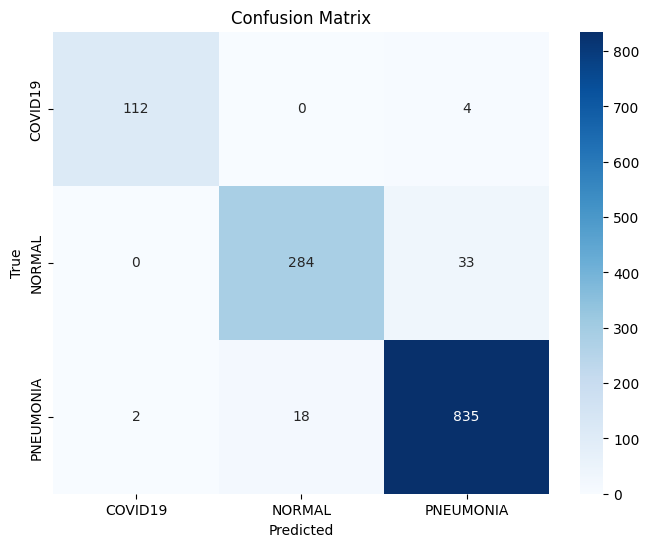

Classification Report:
               precision    recall  f1-score   support

     COVID19       0.98      0.97      0.97       116
      NORMAL       0.94      0.90      0.92       317
   PNEUMONIA       0.96      0.98      0.97       855

    accuracy                           0.96      1288
   macro avg       0.96      0.95      0.95      1288
weighted avg       0.96      0.96      0.96      1288



In [33]:
# Use the model to predict the classes
efficientnet_predicted_labels = np.argmax(efficientnet_model.predict(test_generator), axis=1)

# Generate confusion matrix
efficientnet_cm = confusion_matrix(true_labels, efficientnet_predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(efficientnet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(true_labels, efficientnet_predicted_labels, target_names=test_generator.class_indices.keys()))

#### Thank you for reviewing